In [1]:
%load_ext autoreload
%autoreload 2


# YOLOv7 blog post

Shortly after its publication, YOLOv7 is the fastest and most accurate real-time object detection model for computer vision tasks. The [official paper](https://arxiv.org/abs/2207.02696) demonstrates how this improved architecture surpasses all previous YOLO versions - as well as all other object detection models - in terms of both speed and accuracy on the MS COCO dataset; achieving this performance without utilizing any pretrained weights. Additionally, following all of the [controversy around the naming conventions of previous Yolo models](https://blog.roboflow.com/yolov4-versus-yolov5/), as Yolov7 was released by the same authors that developed [Scaled-Yolov4](https://arxiv.org/abs/2207.02696), the machine learning community seems happy to accept this as the next iteration of the 'official' Yolo family!

At the point that Yolov7 was released, we - as part of Microsoft's Data & AI Service Line - were partway through a challenging object-detection based customer project, in a domain drastically different to COCO. Needless to say, both ourselves and the customer were very excited at the prospect of applying Yolov7 to our problem. Unfortunately, when using the out-of-the-box settings, the results were ... let's just say, not great.

After reading the official paper, we found that, whilst it presents a comprehensive overview on the architectural changes, it omits many details around how the model was trained; for example, which data augmentation techniques were applied, and how the loss function measures that the model is doing a good job! To understand these technicalities, we decided to debug the code directly. However, as the Yolov7 repository is a modified fork of the [YOLOR codebase](https://github.com/WongKinYiu/yolor) - which itself is a fork of [Yolov5](https://github.com/ultralytics/yolov5) - we found that it includes a lot of complex functionality, much of which is not needed when just training a model; for example, being able to specify custom architectures in Yaml format and have these translated into PyTorch models. Additionally, the codebase contains many custom components which have been implemented from scratch - such as a Multi-GPU training loop, several data augmentations, samplers to preserve dataloader workers, and multiple learning rate schedulers - many of which are now available in PyTorch, or other libraries. As a result, there was a lot of code to dissect; it took us a long time to understand how everything worked, as well as the intracies of the training loop which contribute to the model's excellent performance! Eventually, with this understanding, we were able to set up our training recipe to obtain consistently good results on our task.

In this article, we intend to take a practical approach in demonstrating how to train Yolov7 models in custom training scripts, as well as exploring areas such as data augmentation techniques, how to select and modify anchor boxes, and demystifying how the loss function works; (hopefully!) enabling you to build up an intiuition to what is likely to work well for your own problems. As the Yolov7 architecture is well described in detail in the official paper, as well as in many other sources, we are not going to cover this here. Instead, we intend to focus on all of the other details which, whilst contibute to Yolov7's performance, are **not** covered in the paper. This tends to be knowledge which has been accumulated over multiple versions of Yolo models, but can be incredibly difficult to track down for someone just entering the field.  

To illustrate these concepts, we shall be using our own implementation of Yolov7, which utilises the official pretrained weights, but has been written with modularity and readability in mind. This project initially started as an exercise for us to improve our understanding of how Yolov7 works under the hood - in order to better understand how to apply it - but after successfully using it on a few different tasks, we have decided to make it publicly available. Whilst we would recommend using the [official implementation](https://github.com/WongKinYiu/yolov7) if you wish to exactly reproduce the published results on COCO, we find that this implementation is more flexible to apply, and extend, to custom domains. Hopefully, this implementation will provide a clean and clear starting point for anyone wishing to experiment with Yolov7 in their own custom training scripts, as well as providing more transparency around the techniques that were used during training in the original implementation.


In this article, we shall cover:
- Using a pretrained model for inference
- Understanding the Yolov7 Loss calculation
- Finetuning on a new dataset
- Training from scratch

# Data Loading

First, let's take a look at how to load our dataset in the format that Yolov7 expects.

## Selecting a dataset

Throughout this article, we shall use the [Kaggle cars object detection dataset](https://www.kaggle.com/datasets/sshikamaru/car-object-detection); however, as our aim is to demonstrate how Yolov7 can be applied to any problem, this is really the least important part of this work.

Here, we shall use the Kaggle cars object detection dataset; however, as our aim is to demonstrate how Yolov7 can be applied to any problem, this is really the least important part of this work. As this dataset is quite small, it will enable us to train quickly and get fast feedback. Additionally, as the images are quite similar to COCO, it will enable us to experiment with a pretrained model before we do any training.


In [2]:
from pathlib import Path

import pandas as pd

In [3]:
data_path = "data/cars"
data_path = Path(data_path)
images_path = data_path / "training_images"
annotations_file_path = data_path / "annotations.csv"

In [4]:
from example.train_cars import load_cars_df

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:pytorch_accelerated:Setting random seeds
INFO:matplotlib.font_manager:generated new fontManager


The annotations for this dataset are in the form of a .csv file, which associates the image name with the corresponding annotations; where each row represents one bounding box. Whilst there are around 1000 images in the training set, only those with annotations are included in this file. 

We can view the format of this by loading it into a pandas DataFrame. 

In [5]:
pd.read_csv(annotations_file_path)

image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

As it is not usually the case that all images in our dataset contain instances of the objects that we are trying to detect, we would also like to include some images that do not contain cars. To do this, we can define a function to load the annotations which also includes 100 'negative' images. Additionally, as the designated test set is unlabelled, let's randomly take 20% of these images to use as our validation set. 

In [6]:
??load_cars_df

Signature: load_cars_df(annotations_file_path, images_path)
Docstring: <no docstring>
Source:   
def load_cars_df(annotations_file_path, images_path):
    all_images = sorted(set([p.parts[-1] for p in images_path.iterdir()]))
    image_id_to_image = {i: im for i, im in enumerate(all_images)}
    image_to_image_id = {v: k for k, v, in image_id_to_image.items()}

    annotations_df = pd.read_csv(annotations_file_path)
    annotations_df.loc[:, "class_name"] = "car"
    annotations_df.loc[:, "has_annotation"] = True

    # add 100 empty images to the dataset
    empty_images = sorted(set(all_images) - set(annotations_df.image.unique()))
    non_annotated_df = pd.DataFrame(list(empty_images)[:100], columns=["image"])
    non_annotated_df.loc[:, "has_annotation"] = False
    non_annotated_df.loc[:, "class_name"] = "background"

    df = pd.concat((annotations_df, non_annotated_df))

    class_id_to_label = dict(
        enumerate(df.query("has_annotation == True").class_name.unique())
    )

We can now use this function to load our data:

In [7]:
train_df, valid_df, lookups = load_cars_df(annotations_file_path, images_path)

In [8]:
train_df

image        xmin        ymin        xmax        ymax  \
0    vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   
1   vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   
2   vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   
4   vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   
5   vid_4_10100.jpg  447.568741  160.625804  582.083936  232.517696   
..              ...         ...         ...         ...         ...   
91  vid_4_13060.jpg         NaN         NaN         NaN         NaN   
93  vid_4_13100.jpg         NaN         NaN         NaN         NaN   
95  vid_4_13240.jpg         NaN         NaN         NaN         NaN   
97  vid_4_13280.jpg         NaN         NaN         NaN         NaN   
98  vid_4_13300.jpg         NaN         NaN         NaN         NaN   

    class_name  has_annotation  image_id  class_id  
0          car            True         0       0.0  
1          car            True         1       0.0  
2          car            True         3       0.0  
4          car            True         4       0.0  
5          car            True         6       0.0  
..         ...             ...       ...       ...  
91  background           False       142       NaN  
93  background           False       144       NaN  
95  background           False       146       NaN  
97  background           False       148       NaN  
98  background           False       149       NaN  

[465 rows x 9 columns]

To make it easier to associate predictions with an image, we have assigned each image a unique id; in this case it is just an incrementing integer count. Additionally, we have added an integer value to represent the classes that we want to detect, which is a single class - 'car' - in this case.

Generally, object detection models reserve `0` as the background class, so class labels should start from `1`. This is **not** the case for Yolov7, so we start our class encoding from `0`. For images that do not contain a car, we do not require a class id. We can confirm that this is the case by inspecting the lookups returned by our function.

In [9]:
lookups.keys()

dict_keys(['image_id_to_image', 'image_to_image_id', 'class_id_to_label', 'class_label_to_id'])

In [10]:
lookups['class_label_to_id'], lookups['class_label_to_id']

({'car': 0}, {'car': 0})

Finally, let's use our dataset to see the number of images in each class for our training and validation sets. As an image can have multiple annotations, we need to make sure that we account for this when calculating our counts:

In [11]:
print(f"Num. annotated images in training set: {len(train_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in training set: {len(train_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in training set: {len(train_df.image.unique())}")
print('------------')

print(f"Num. annotated images in validation set: {len(valid_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in validation set: {len(valid_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in validation set: {len(valid_df.image.unique())}")

Num. annotated images in training set: 256
Num. Background images in training set: 68
Total Num. images in training set: 324
------------
Num. annotated images in validation set: 99
Num. Background images in validation set: 32
Total Num. images in validation set: 131


## Create a Dataset Adaptor

Usually, at this point, we would create a PyTorch dataset specific to the model that we shall be training. 

However, we often use the pattern of first creating a dataset 'adaptor' class, with the sole responsibility of wrapping the underlying data sources and loading this approriately. This way, we can easily switch out adaptors when using different datasets, without changing any preprocessing logic which is specific to the model that we are training.

Therefore, let’s focus for now on creating a `CarsDatasetAdaptor` class, which converts the specific raw dataset format into an image and corresponding annotations. Additionally, let's load the image id that we assigned, as well as the height and width of our image, as they may be useful to us later on.

An implementation of this is presented below:

In [12]:
from example.train_cars import CarsDatasetAdaptor

In [13]:
??CarsDatasetAdaptor

Init signature: CarsDatasetAdaptor(*args, **kwds)
Docstring:     
An abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`, which is expected to return the size of the dataset by many
:class:`~torch.utils.data.Sampler` implementations and the default options
of :class:`~torch.utils.data.DataLoader`.

.. note::
  :class:`~torch.utils.data.DataLoader` by default constructs a index
  sampler that yields integral indices.  To make it work with a map-style
  dataset with non-integral indices/keys, a custom sampler must be provided.
Source:        
class CarsDatasetAdaptor(Dataset):
    def __init__(
        self,
        images_dir_path,
        annotations_dataframe,
        transforms=None,
    ):
        self.images_dir_path = Path(images_dir_path)
     

Notice that, for our background images, we are just returning an empty array for our bounding boxes and class ids.

Using this, we can confirm that the length of our dataset is the same as the total number of training images that we calculated earlier.

In [14]:
ds = CarsDatasetAdaptor(images_path, train_df)

In [15]:
len(ds)

324

Now, we can use this to visualise some of our images, as demonstrated below.

In [16]:
from yolov7.plotting import show_image

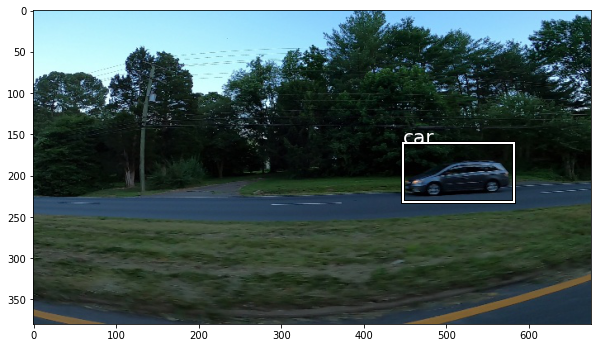

Image id: 6
Image size: (380, 676)


In [17]:
idx = 4
image, xyxy_bboxes, class_ids, image_idx, image_size = ds[idx]
show_image(image, xyxy_bboxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in class_ids])
print(f'Image id: {image_idx}')
print(f'Image size: {image_size}')

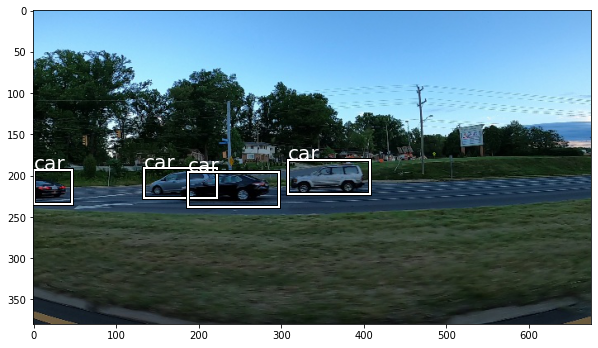

Image id: 848
Image size: (380, 676)


In [18]:
idx = 204
image, xyxy_bboxes, class_ids, image_idx, image_size = ds[idx]
show_image(image, xyxy_bboxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in class_ids])
print(f'Image id: {image_idx}')
print(f'Image size: {image_size}')

## Create Yolov7 dataset

Now that we have created our dataset adaptor, let's create a dataset which preprocesses our inputs into the format required by Yolov7; these steps should remain the same regardless of the dataset that we are using. 

An implementation of this is presented below:

In [19]:
from yolov7.dataset import Yolov7Dataset

In [20]:
??Yolov7Dataset

Init signature: Yolov7Dataset(*args, **kwds)
Source:        
class Yolov7Dataset(Dataset):
    """
    A dataset which takes an object detection dataset returning (image, boxes, classes, image_id, image_hw)
    and applies the necessary preprocessing steps as required by Yolov7 models.

    By default, this class expects the image, boxes (N, 4) and classes (N,) to be numpy arrays,
    with the boxes in (x1,y1,x2,y2) format, but this behaviour can be modified by
    overriding the `load_from_dataset` method.
    """

    def __init__(self, dataset, transforms=None):
        self.ds = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.ds)

    def load_from_dataset(self, index):
        image, boxes, classes, image_id, shape = self.ds[index]
        return image, boxes, classes, image_id, shape

    def __getitem__(self, index):
        image, boxes, classes, image_id, original_image_size = self.load_from_dataset(
            index
        )

   

Let's wrap our data adaptor using this dataset and inspect some of the outputs:

In [21]:
yolo_ds = Yolov7Dataset(ds)

Image: torch.Size([3, 380, 676])
Labels: tensor([[0.0000, 0.0000, 0.7616, 0.5173, 0.1990, 0.1892]])


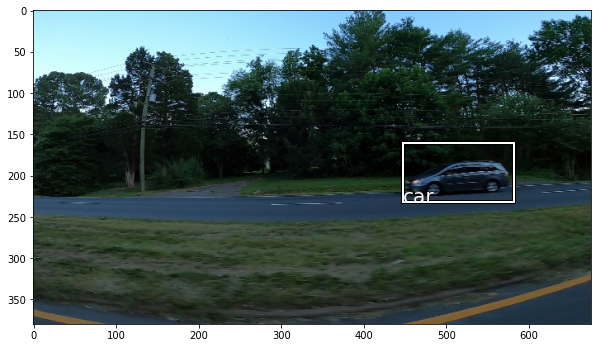

Image id: 6
Image size: tensor([380, 676])


In [22]:
idx = 4
image_tensor, labels, image_id, image_size = yolo_ds[idx]

print(f'Image: {image_tensor.shape}')
print(f'Labels: {labels}')

# denormalize boxes
boxes = labels[:, 2:]
boxes[:, [0, 2]] *= image_size[1]
boxes[:, [1, 3]] *= image_size[0]

show_image(image_tensor.permute( 1, 2, 0), boxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in labels[:, 1]], 'cxcywh')
print(f'Image id: {image_id}')
print(f'Image size: {image_size}')

As we haven't defined any transforms, the output is largely the same, with the main exception being that the boxes are now in normalized cxcywh format and all of our outputs have been converted into tensors.

One thing to note is that the our labels take the form `[0, class_id, ncx, ncy, nw, nh]`. The zero space at the start of the tensor will be utilised by the collate function later on.

### Transforms

Now, let's define some transforms! For this, we shall use the excellent Albumentations library, which provides many options for transforming both images and bounding boxes.

Whilst the transforms that we select will largely be domain specific, here, we shall 's define similar transforms to those used in the original implementation.

These are:
- resize the image to the given input (multiple of 640) whilst maintaining the aspect ratio
- If the image is not square, apply padding. For this, we shall follow the paper in using a grey padding, this is an arbitary choice.

During training:
- horizontal flip.


In [23]:
from yolov7.dataset import create_yolov7_transforms

We can use the following function to create these transforms as demonstrated below:

In [24]:
??create_yolov7_transforms

Signature:
create_yolov7_transforms(
    image_size=(640, 640),
    training=False,
    training_transforms=(HorizontalFlip(always_apply=False, p=0.5),),
)
Docstring: <no docstring>
Source:   
def create_yolov7_transforms(
    image_size=(640, 640),
    training=False,
    training_transforms=(A.HorizontalFlip(p=0.5),),
):
    transforms = [
        A.LongestMaxSize(max(image_size)),
        A.PadIfNeeded(
            image_size[0],
            image_size[1],
            border_mode=0,
            value=(114, 114, 114),
        ),
    ]

    if training:
        transforms.extend(training_transforms)

    return A.Compose(
        transforms,
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
    )
File:      /mnt/yolov7/dataset.py
Type:      function


Now, let's recreate our dataset, this time passing the default transforms that will be used during evaluation. For our target image size, we shall use `640` which is the value that the smaller Yolov7 models were trained on. In general, we can select any multiple of 8 for this.

In [25]:
target_image_size = 640

In [26]:
yolo_ds = Yolov7Dataset(ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))

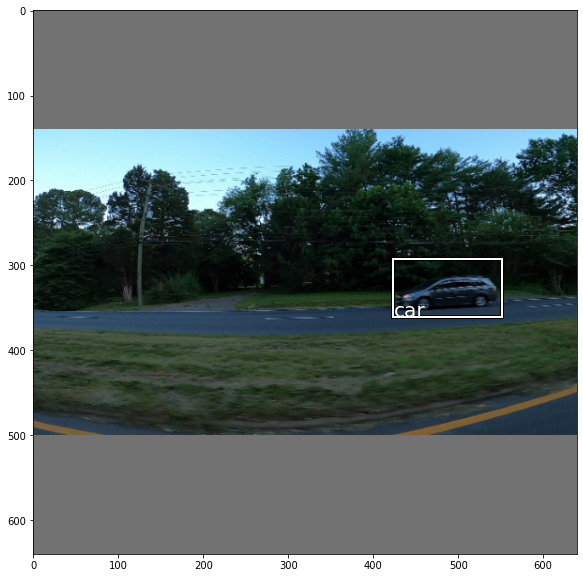

Image id: 6
Original Image size: tensor([380, 676])
Resized Image size: torch.Size([640, 640])


In [27]:
idx = 4
image_tensor, labels, image_id, image_size = yolo_ds[idx]

boxes = labels[:, 2:]
boxes[:, [0, 2]] *= target_image_size
boxes[:, [1, 3]] *= target_image_size

show_image(image_tensor.permute( 1, 2, 0), boxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in labels[:, 1]], 'cxcywh')
print(f'Image id: {image_id}')
print(f'Original Image size: {image_size}')
print(f'Resized Image size: {image_tensor.shape[1:]}')

Using these transforms, we can see that our image has been resized to our target size and padding has been applied. The reason that padding is used is so that we can maintain the aspect ratio of the objects in the images, but have a common size for images in our dataset; enabling us to batch them efficiently!

# Using a pretrained model

Now that we have explored how to load and prepare our data, let's move on to take a look at how we can leverage a pretrained model to make some predictions!

## Loading the model

So that we can understand how to interface with the model, let's load a pretrained checkpoint and use this for inference on some images in our dataset. As this checkpoint was trained on COCO, which contains images of cars, we can assume that the model should perform moderately well on this task out of the box. To see the models that are available, we can import the `AVAILABLE_MODELS` variable.

In [28]:
from yolov7 import AVAILABLE_MODELS

AVAILABLE_MODELS

['yolov7',
 'yolov7x',
 'yolov7-tiny',
 'yolov7-w6',
 'yolov7-d6',
 'yolov7-e6',
 'yolov7-e6e']

Here, we can see that the available models are the architectures defined in the original paper. Let's create the standard `yolov7` model, using the `create_yolov7_model` function

In [29]:
from yolov7 import create_yolov7_model

In [30]:
model = create_yolov7_model('yolov7', num_classes=80, pretrained=True)

Downloading: "https://github.com/Chris-hughes10/Yolov7-training/releases/download/alpha/yolov7_training_state_dict.pt" to /root/.cache/torch/hub/checkpoints/yolov7_training_state_dict.pt


Transferred 564/566 items from https://github.com/Chris-hughes10/Yolov7-training/releases/download/alpha/yolov7_training_state_dict.pt


In [31]:
model.eval();

Now, let's take a look at the model's predictions. The forward pass through the model will return the raw feature maps given by the FPN heads, to convert these into meaningful predictions, we can use the `postprocess` method.

In [32]:
import torch

with torch.no_grad():
    model_outputs = model(image_tensor[None])
    preds = model.postprocess(model_outputs, conf_thres=0., multiple_labels_per_box=False)

In [33]:
preds[0].shape

torch.Size([25200, 6])

Inspecting the shape, we can see that the model has made 25,200 predictions! Each prediction has an associated tensor of length 6 - the entries correspond to the bounding box coordinates in xyxy format, a confidence score, and a class index.

In [34]:
preds

[tensor([[-8.4173e-01, -9.4058e-01,  6.4309e+00,  7.3230e+00,  7.5352e-08,
           0.0000e+00],
         [ 5.5791e+00, -8.7718e-01,  2.1090e+01,  8.4734e+00,  6.2382e-11,
           0.0000e+00],
         [ 1.3647e+01, -1.1971e+00,  2.9596e+01,  1.0926e+01,  3.2486e-11,
           0.0000e+00],
         ...,
         [ 4.1780e+02,  5.1613e+02,  6.8559e+02,  7.3991e+02,  7.4535e-09,
           0.0000e+00],
         [ 4.7073e+02,  5.2559e+02,  6.9972e+02,  7.2728e+02,  1.8377e-08,
           0.0000e+00],
         [ 4.7766e+02,  5.1540e+02,  7.7483e+02,  7.3268e+02,  5.6421e-08,
           0.0000e+00]])]

Often, object detection models tend to make a lot of similar, overlapping predictions. Whilst there are many ways of dealing with this, in the original paper, the authors used Non-maximum-suppression (NMS) to solve this problem. We can apply NMS, as well as a secondary round of confidence thresholding, using the function below. In addition, during postprocessing, we often want to filter our any predictions with a confidence level below a predefined theshold, let's increase our confidence threshold here

In [35]:
from yolov7.trainer import filter_eval_predictions

In [36]:
??filter_eval_predictions

Signature:
filter_eval_predictions(
    predictions: List[torch.Tensor],
    confidence_threshold: float = 0.2,
    nms_threshold: float = 0.65,
) -> List[torch.Tensor]
Docstring: <no docstring>
Source:   
def filter_eval_predictions(
    predictions: List[Tensor],
    confidence_threshold: float = 0.2,
    nms_threshold: float = 0.65,
) -> List[Tensor]:
    nms_preds = []
    for pred in predictions:
        pred = pred[pred[:, 4] > confidence_threshold]

        nms_idx = torchvision.ops.batched_nms(
            boxes=pred[:, :4],
            scores=pred[:, 4],
            idxs=pred[:, 5],
            iou_threshold=nms_threshold,
        )
        nms_preds.append(pred[nms_idx])

    return nms_preds
File:      /mnt/yolov7/trainer.py
Type:      function


In [37]:
nms_predictions = filter_eval_predictions(preds, confidence_threshold=0.1)

In [38]:
nms_predictions[0].shape

torch.Size([1, 6])

After applying NMS, we can see that now we only have a single prediction for this image. Let's visualise how this looks:

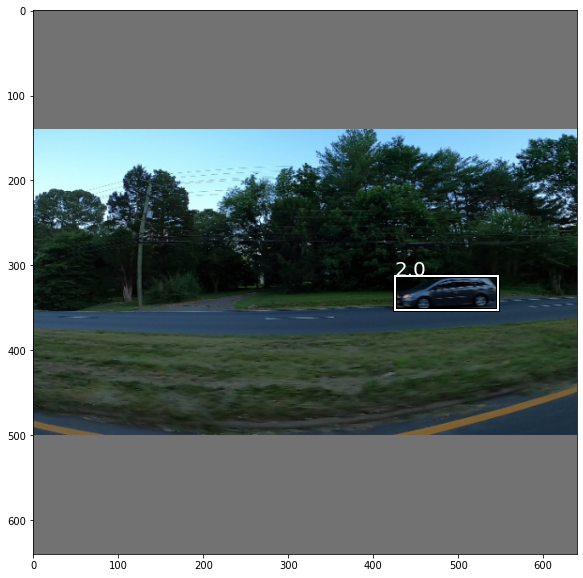

Image id: 6
Original Image size: tensor([380, 676])
Resized Image size: torch.Size([640, 640])


In [39]:
boxes = nms_predictions[0][:, :4]
class_ids = nms_predictions[0][:, -1]

show_image(image_tensor.permute( 1, 2, 0), boxes.tolist(), class_ids.tolist())
print(f'Image id: {image_id}')
print(f'Original Image size: {image_size}')
print(f'Resized Image size: {image_tensor.shape[1:]}')

We can see that this looks pretty good! The prediction from the model is actually tighter around the car than the ground truth!

Now that we have our prediction, the only thing to note is that the bounding box is relative to the *resized* image size. To scale our predictions back to the original image size, we can use the following function:

In [40]:
from yolov7.models.yolo import scale_bboxes_to_original_image_size

In [41]:
??scale_bboxes_to_original_image_size

Signature:
scale_bboxes_to_original_image_size(
    xyxy_boxes,
    resized_hw,
    original_hw,
    is_padded=True,
)
Docstring: <no docstring>
Source:   
def scale_bboxes_to_original_image_size(
    xyxy_boxes, resized_hw, original_hw, is_padded=True
):
    scaled_boxes = xyxy_boxes.clone()
    scale_ratio = resized_hw[0] / original_hw[0], resized_hw[1] / original_hw[1]

    if is_padded:
        # remove padding
        pad_scale = min(scale_ratio)
        padding = (resized_hw[1] - original_hw[1] * pad_scale) / 2, (
            resized_hw[0] - original_hw[0] * pad_scale
        ) / 2
        scaled_boxes[:, [0, 2]] -= padding[0]  # x padding
        scaled_boxes[:, [1, 3]] -= padding[1]  # y padding
        scale_ratio = (pad_scale, pad_scale)

    scaled_boxes[:, [0, 2]] /= scale_ratio[1]
    scaled_boxes[:, [1, 3]] /= scale_ratio[0]

    # Clip bounding xyxy bounding boxes to image shape (height, width)
    scaled_boxes[:, 0].clamp_(0, original_hw[1])  # x1
    scaled_boxes[:, 1]

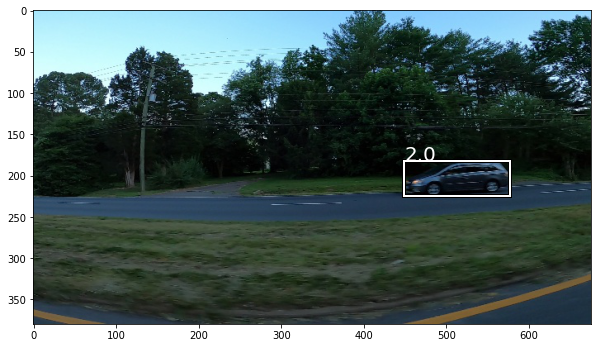

Image id: 6
Image size: tensor([380, 676])


In [42]:
idx = 4
image, _, _, image_idx, original_image_size = ds[idx]
show_image(image,
           scale_bboxes_to_original_image_size(boxes,original_hw=original_image_size, resized_hw=image_tensor.shape[1:]).tolist(),
           class_ids.tolist())
print(f'Image id: {image_idx}')
print(f'Image size: {image_size}')

# Understanding the Loss calculation

Before we can start training, in addition to a model architecture, we need a loss function which will enable us to measure how well our model is performing; in order to be able to update our parameters. Since Object Detection is a difficult problem to teach a model, the loss functions of such models are usually quite complex and YOLOv7 is not an exception. Here, we shall do our best to illustrate the intuitions behind it to facilitate its understanding.

Before we can delve deeper into the actual loss function, let's cover a few background concepts that we need to understand.

## Anchor boxes

One of the main difficulties of object detection is outputting detection boxes. That is, how do we train a model to create a bounding box and localize it correctly in an image?

There are a few different approaches, but the YOLOv7 family is what we call an **anchor-based** model. In these models, the general philosophy is to first create lots of potential bounding boxes, then select the most promising options to match to our target objects; slightly moving and resizing them as necessary to obtain the best possible fit.

The basic idea is that we draw a grid on top of each image and, at each grid intersection (**anchor point**), generate candidate boxes (**anchor boxes**) based on a number of **anchor sizes**. That is, the same set of boxes is repeated at each anchor point. This way, the task that model has to learn, slightly relocating and resizing these boxes, is simpler than generating boxes from scratch.


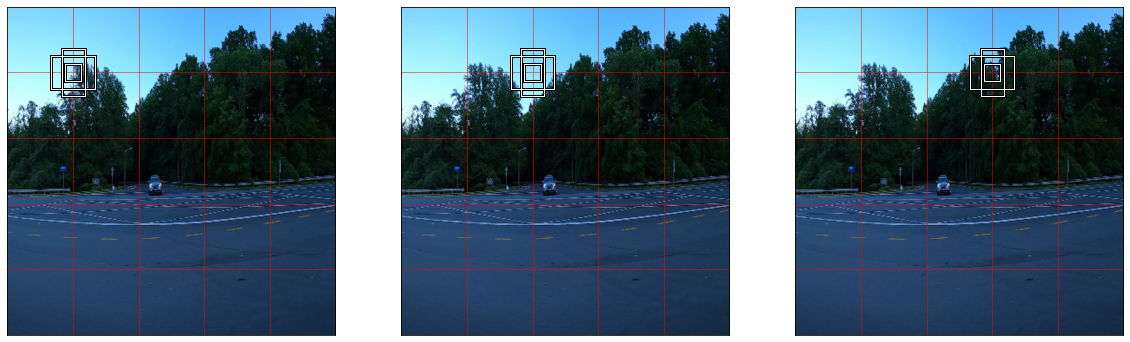

In [104]:
import matplotlib.pyplot as plt
import matplotlib as mpl

img_size = 640
img = Image.fromarray(ds[0][0]).resize((img_size, img_size))

def draw_box(ax, cx, cy, w, h, is_target=False):
    x = cx - w/2
    y = cy - h/2
    black_patch = mpl.patches.Rectangle((x, y), w, h, lw=3, edgecolor='k', facecolor='none', zorder=1)
    linestyle = "-" if is_target else "--"
    white_patch = mpl.patches.Rectangle((x, y), w, h, lw=1, edgecolor='w', facecolor='none', linestyle=linestyle, zorder=2)
    ax.add_patch(black_patch)
    ax.add_patch(white_patch)

def draw_grid(ax, img_size, stride):
    for i in range(stride, img_size, stride):
        ax.axvline(i, c="r", lw=0.5, zorder=0)
        ax.axhline(i, c="r", lw=0.5, zorder=0)

fig, axs = plt.subplots(1, 3, figsize=(20,8))
for i in range(3):
    ax = axs[i]
    ax.imshow(img)
    ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    draw_grid(ax, img_size, 128)
    for box in boxes:
        cx = 128*(i + 1)
        cy = 128
        draw_box(ax, cx, cy, 45, 90, is_target=True)
        draw_box(ax, cx, cy, 85, 64, is_target=True)
        draw_box(ax, cx, cy, 32, 32, is_target=True)

*An example of anchor boxes generated at a sample of anchor points.*

However, one issue with this approach is that our target, ground truth, boxes can range in size - from tiny to huge! Therefore, it is usually not possible to define a single set of anchor sizes that can be matched to all targets. For this reason, anchor-based model architectures usually employ a Feature-Pyramid-Network (FPN) to assist with this; YOLOv7 is no exception.

### Feature Pyramid Networks (FPN)

The main idea behind FPNs (introduced in [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)) is to leverage the nature of convolutional layers - which reduce the size of the feature space, and increase the coverage of each feature in the initial image - to output predictions at different scales. FPNs are usually implemented as a stack of convolutional layers, as we can see by inspecting the detection head of our yolov7 model.

In [97]:
model.detection_head

Yolov7DetectionHead(
  (m): ModuleList(
    (0): Conv2d(256, 255, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(512, 255, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 255, kernel_size=(1, 1), stride=(1, 1))
  )
  (ia): ModuleList(
    (0): ImplicitAdd()
    (1): ImplicitAdd()
    (2): ImplicitAdd()
  )
  (im): ModuleList(
    (0): ImplicitMultiply()
    (1): ImplicitMultiply()
    (2): ImplicitMultiply()
  )
)

Whilst we could simply take the outputs of the final layer as predictions, as the deeper convolutional layers implicitly utilise the information from previous layers to learn more high-level features, they do not have access to the information of how to detect the lower-level features contained in earlier layers; this can result in poor performance when detecting smaller objects.

For this reason, a top-down pathway and lateral connections are added to the regular bottom-up pathway (normal flow of a convolution layer). The top-down pathway hallucinates higher resolution features by upsampling spatially coarser, but semantically stronger, feature maps from higher pyramid levels. Then, these features are enhanced with features from the bottom-up pathway through the lateral connections. The bottom-up feature map is of lower-level semantics, but its activations are more accurately localized as it was subsampled fewer times.


In summary, FPNs provide semantically strong features at multiple scales which make them extremely well suited for object detection. The connections that YOLOv7 implements in its FPN are illustrated in the figure below:

![yolov7_head_arch](yolov7_head_arch.png)

*Representation of the YOLOv7 family Feature Proposal Network architecture. Source: YOLOv7 paper.*

Here, we can see that we have a "Normal model" and a "Model with auxiliary head". This is because some of the larger models in the Yolov7 family use deep supervision when training; that is, they leverage the outputs of deeper layers in the loss in order to try and better learn the task. We shall explore this further later on.

From the image, we can see that each layer in the FPN (also known as each FPN head), has a feature scale that is half the size of the previous one (the scale is the same for each Lead head and its corresponding Aux head). This can be understood as each subsequent FPN head "seeing" object scales twice as big as the previous one. We can leverage that by assigning grids with different **strides** (grid cell side size), and proportional anchor sizes, to each FPN head.

For instance, the anchor configuration for the basic `yolov7` model looks like this:

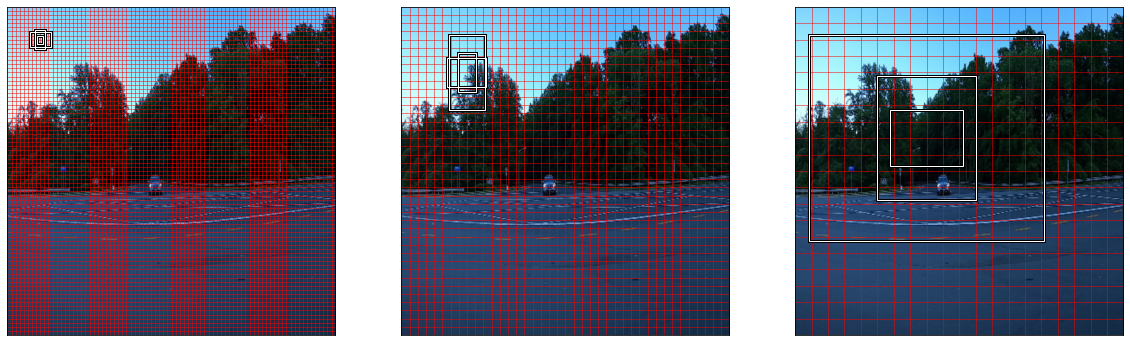

In [98]:
stride_box = {
    int(s.item()): t.tolist()
    for s, t in zip(model.detection_head.strides, model.detection_head.anchor_sizes_per_layer)
}

fig, axs = plt.subplots(1, 3, figsize=(20,8))
for i, (stride, boxes) in enumerate(stride_box.items()):
    ax = axs[i]
    ax.imshow(img)
    ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    draw_grid(ax, img_size, stride)
    for box in boxes:
        draw_box(ax, stride*8, stride*8, box[0]*stride, box[1]*stride, is_target=True)

# fig.savefig("media/anchor_example_lite.png", dpi=50)

*Illustration of the anchor grid and the different (default) anchor box sizes for each fpn head in the main model in the YOLOv7 family*

As we can see, we have anchor box sizes and grids that cover completely different scales: from tiny objects to objects that can occupy the whole image.

Now, that we understand these ideas conceptially, let's take a look at the FPN outputs that come out of our model; which is what will be used to calculate our loss.


### Breaking down the FPN outputs

Recall that, when we made our predictions earlier, we used the model's `postprocess` method to convert the raw fpn outputs into usable bounding boxes. Now that we understand the intiuition behind what the FPN is trying to do, let's inspect these raw outputs.

In [99]:
with torch.no_grad():
    fpn_outputs = model(image_tensor[None])

The outputs of our model are always a `List[Tensor]`, where each component corresponds to a head of the FPN. For models that use Deep Supervision, the Aux Head outputs come after the Lead Head outputs (always the same number of each, both sides of the pair ordered equally). For the rest, including the one we are using here, only the Lead Head outputs are present.

In [102]:
type(fpn_outputs), len(fpn_outputs)

(list, 3)

In [103]:
for output in fpn_outputs:
    print(output.shape)

torch.Size([1, 3, 80, 80, 85])
torch.Size([1, 3, 40, 40, 85])
torch.Size([1, 3, 20, 20, 85])


Inspecting the shape of each FPN output, we can see that each one has the following dimensions:
```
[n_images, n_anchor_sizes, n_grid_rows, n_grid_cols, n_features]

```
where:

- `n_images` - Images in batch, batch size.
- `n_anchor_sizes` - The anchor sizes associated with the head (usually 3).
- `n_grid_rows` - The number of anchors vertically, `img_height / stride`.
- `n_grid_cols` - The number of anchors horizontally, `img_width / stride`.
- `n_features` - `5 + num_classes`
    - `cx` - Horizontal correction for the anchor box center.
    - `cy` - Vertical correction for the anchor box center.
    - `w` - Width correction for the anchor box.
    - `h` - Height correction for the anchor box.
    - `obj_score` - Score proportional to the probability of an object being contained inside the anchor box.
    - `cls_score` - One per class, score proportional to the probability of that being the class of the object.


When these outputs are mapped into useful predictions during post-processing, we apply the following operations:



- `cx`, `cy` - `final = 2 * sigmoid(initial) - 0.5` ; $(-\inf, \inf) \rightarrow (-0.5, 1.5)$
    - The model can only move the anchor center from 0.5 cell behind to 1.5 cells forward. Note that for the loss (i.e. when we train) we use grid coordinates.
- `w`, `h` - `final = (2 * sigmoid(initial)**2`; $(-\inf, \inf) \rightarrow (0, 4)$
    - The model can make the anchor box arbitrarily smaller but at most 4 times bigger. Larger objects, outside of this range, must be predicted by the next FPN head.
- `obj_score` - `final = sigmoid(initial)`; $(-\inf, \inf) \rightarrow (0, 1)$
    - Makes sure the score is mapped to a probability.
- `cls_score` - `final = sigmoid(initial)`; $(-\inf, \inf) \rightarrow (0, 1)$
    - Makes sure the score is mapped to a probability.



### Center Priors

Now, it is easy to see that if we put 3 anchor boxes in each anchor point of each of the grids, we end up with a lot of boxes; `3*80*80 + 3*40*40 + 3*20*20=25200` for each 640x640px image to be exact! The issue is that most of these predictions are not going to contain an object, which we classify as 'background'. Depending on the sequence of operations that we need to apply to each prediction, computations can easily stack up and slow down the training! 

To make the problem cheaper computationally, the YOLOv7 loss finds first the anchor boxes that are likely to match each target box, and treats them differently -  these are known as the **center prior** anchor boxes. This process is applied at each FPN head, for each target box, across all images in batch at once.

Each anchor - which are the coordinates in our grid - defines a grid cell; where we consider the anchor to be at the top left of its correspnding grid cell. Subsequently, each cell (except cells on the border) has 4 adjacent cells (top, bottom, left, right). Each target box, for each FPN head, lies somewhere inside a grid cell. Imagine that we have the following grid and the center of a target box is represented by a `*`:


```
  |      |      |
--+------+------+--
  |      |      |   
  |      |      |      
--+------+------+--
  |      |    * |   
  |      |      |  
--+------+------+--
  |      |      |
```



Based on the way the model is designed and trained, the `x` and `y` corrections that it can output are in the range of `[-0.5, 1.5]` grid cells. Thus, only a subset of the closest anchor boxes will be able to match the target center. We select some of these anchor boxes to represent the **center prior** for the target box.

- For the Lead Heads, we use a **fine Center Prior**, which is a more targeted selection. This is comprised of **3 anchors per head**: the anchor associated the cell containing the target box centre, alongside the anchors for the 2 closest grid cells to the target box center. In the diagram, the Center Prior anchors are marked with an `X`.

```
  |      |      |
--+------X------+--
  |      |      |   
  |      |      |      
--+------X------X--
  |      |    * |   
  |      |      |  
--+------+------+--
  |      |      |
```

- For the Auxiliary Heads (for models that use deep supervision), we use a **coarse Center Prior**, which is a less targeted selection. This is comprised of **5 anchors per head**: the anchor of the cell containing the target box centre, alongside all 4 adjacent grid cells.

```
  |      |      |
--+------X------+--
  |      |      |   
  |      |      |      
--X------X------X--
  |      |    * |   
  |      |      |  
--+------X------+--
  |      |      |
```

The reasoning behind this fine and coarse distinction is that the learning ability of Auxiliary Heads is lower than that of the Lead Heads,  because the Lead Heads are deeper in the network. Thus, we try to avoid limiting too much from where the Auxiliary Head can learn to make sure we do not lose valuable information.

Similarly to the coordinates corrections, the model can only only apply a multiplicative modifier to the width and height of each anchor box in the interval `[0, 4]`. This means that, at most, it can make the sides of the anchor boxes 4 times bigger. Therefore, from the anchor boxes selected as Center Prior, we filter those that are either 4 times bigger or smaller than the target box.

In summary, the Center Prior is comprised by the anchor boxes whose anchor is close enough to the target box center and whose sides are not too far off from the target box side size.

## Optimal Transport Assignment

One of the difficulties when evaluating object detection models is being able to match predicted boxes to target boxes in order to quantify if the model is doing a good job or not.

The simplest approach is to define an Intersection over Union (IoU) threshold and decide based on that. While this generally works, it becomes problematic when there are occlusions, ambiguity or when multiple objects are very close together. Optimal Transport Assignment or OTA (introduced in [Optimal Transport Assignment for Object Detection](https://arxiv.org/abs/2103.14259)) aims to solve some of these problems by considering label assignment a global optimization problem for each image.

The main intuition consists in considering each target box a supplier of `k` positive label assignments and each predicted box a demander of either one positive label assignment or one background assignment. `k` is dynamic and depends on each target box. Then, transporting one positive label assignment from target box to predicted box has a cost based on classification and regression. Finally, the goal is to find a transportation plan (label assignment) that minimizes the total cost over the image.

This can be done using an off-the-shelf solver, but YOLOv7 implements **simOTA** (introduced in the [YOLOX paper](https://arxiv.org/abs/2107.08430)), a simplified version of the OTA problem. With the goal of reducing the computational cost of label assignment, it assigns the $k$ predicted boxes for each target that have the lowest transportation cost instead of solving the global problem. The the Center Prior boxes are used as candidates for this process.

This helps us to further filter the amount of model outputs that can potentially be matched to a ground truth target.

## Loss algorithm

Now that we have introduced the most complicated pieces used in the Yolov7 loss calculation, we can break down the algorithm used into the following steps:

1. For each FPN head (or each FPN head and Aux FPN head pair if Aux heads used):
    1. Find the Center Prior anchor boxes.
    1. Refine the candidate selection through the simOTA algorithm. Always use lead FPN heads for this.
    1. Obtain the **objectness loss** score using Binary Cross Entropy Loss between the predicted objectness probability and the [Complete Intersection over Union](https://arxiv.org/abs/1911.08287)  (CIoU) with the matched target as ground truth. If there are no matches, this is 0.
    1. If there are any selected anchor box candidates, also calculate (otherwise they are just 0):
        - The **box (or regression) loss**, defined as the `mean(1 - CIoU)` between all candidate anchor boxes and their matched target.
        - The **classification loss**, using Binary Cross Entropy Loss between the predicted class probabilities for each anchor box and a one-hot encoded vector of the true class of the matched target.
    1. If model uses auxiliary heads, add each component obtained from the aux head to the corresponding main loss component (i.e., `x = x + aux_wt*aux_x`). The contribution weight is defined by a predefined hyperparameter.
    1. Multiply the objectness loss by the corresponding FPN head weight (predefined hyperparameter).
1. Multiple each loss component (objectness, classification, regression) by their contribution weight (predefined hyperparameter).
1. Sum the already weighted loss components.
1. Multiply the final loss value by the batch size.

As a technical detail, the loss reported during evaluation is made computationally cheaper by skipping the simOTA and never using the auxiliary heads, even for the models that fashion deep supervision.

Whilst this process contains a lot of complexity, in practice, this is all encapsulated in a single class, which can be created as demonstrated below:

In [108]:
from yolov7 import create_yolov7_loss

In [110]:
loss_fn = create_yolov7_loss(model,
    image_size=640,
    box_loss_weight=0.05,
    cls_loss_weight=0.3,
    obj_loss_weight=0.7,
    aux_loss=False,
    ota_loss=True,)

# Finetuning a model

Now that we understand how to use a pretrained model to make predictions, and how our loss function measures the quality of these predictions, let's look at how we can finetune a model to a custom task. To obtain the level of performance reported in the paper, Yolov7 was trained using a variety of techniques. However, for our purposes, lets start with the minimal possible training loop required, before gradually introducing different techniques. 

To handle the boilerplate aspects of the training loop, let's use PyTorch-accelerated. This will enable us to define only the the parts of the training loop which are relevant to our use case, without having to manage all of the boilerplate. To do this, we can override parts of the default `Trainer` and create a trainer specific to our Yolov7 model, as demonstrated below:


In [43]:
from yolov7.trainer import Yolov7Trainer

In [44]:
??Yolov7Trainer

Init signature:
Yolov7Trainer(
    model,
    loss_func,
    optimizer,
    callbacks,
    filter_eval_predictions_fn=None,
)
Docstring:     
The Trainer is designed to encapsulate an entire training loop for a specific task, bringing together the model,
loss function and optimizer, and providing a specification of the behaviour to execute for each step of the training
process.

The trainer has been implemented such that it provides (overridable) implementations of the parts of training
that rarely change after they have been defined – such as creating a data loader, or how a batch of data is fed to
the model – whilst remaining decoupled from components that are likely to change, such as the model, dataset,
loss function and optimizer.
Source:        
class Yolov7Trainer(Trainer):
    YOLO7_PADDING_VALUE = -2.0

    def __init__(
        self,
        model,
        loss_func,
        optimizer,
        callbacks,
        filter_eval_predictions_fn=None,
    ):
        super().__init__

Our training step is quite straightforward, with the only modification being that we need to extract the total loss from the dictionary that is returned. For the evaluation step, we first calculate the losses, and then retrieve the detections.

### Evaluation logic

To evaluate our model's performance on this task, we can use Mean Average Precision (mAP); a standard metric for object detection tasks. Perhaps the most widely used (and trusted) implementation of mAP, is the class that is included in the PyCOCOTools package, which is used to evaluate official COCO leaderboard submissions.

However, as this does not not have the most inituitive interface, we can create a simple wrapper around this, to make it a little more user-friendly. Additionally, as for many cases outside the COCO competition leaderboard, it can be advantageous to evaluate predictions using a fixed IoU threshold - as opposed to the range of IoUs that is used by default - we have added an option to do this to our evaluator.

Our implementation of this is presented below:

In [45]:
from yolov7.evaluation import COCOMeanAveragePrecision

In [46]:
??COCOMeanAveragePrecision

Init signature: COCOMeanAveragePrecision(iou_threshold: float = None, verbose=False)
Source:        
class COCOMeanAveragePrecision:
    """
    Computes the Mean-Average-Precision (mAP) for object detection predictions and ground truth targets.

    This class provides an interface to the mAP implementation included with pycocotools, which is the standard
    implementation for the benchmarking of object detection models in academic papers.

    """

    # Box area range is a concept needed for benchmarking models, we do not need that.
    # Thus, we pick one that can just fit any prediction.
    AREA_RANGE = np.array([0**2, 1e5**2])
    AREA_RANGE_LABEL = "all"
    # Maximum number of predictions we account for each image.
    MAX_PREDS = 100

    def __init__(self, iou_threshold: float = None, verbose=False):
        """
        :param iou_threshold: If set, the IoU threshold at which mAP will be calculated. Otherwise, the COCO default range of IoU thresholds will be used.
        :

To encapsulate our evaluation logic to use during training, let's create a callback for this; which will be updated at the end of each evaluation step and then calculated at the end of each evaluation epoch. 

In [47]:
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback

In [48]:
??CalculateMeanAveragePrecisionCallback

Init signature:
CalculateMeanAveragePrecisionCallback(
    targets_json,
    iou_threshold=None,
    save_predictions_output_dir_path=None,
    verbose=False,
)
Source:        
class CalculateMeanAveragePrecisionCallback(TrainerCallback):
    """
    A callback which accumulates predictions made during an epoch and uses these to calculate the Mean Average Precision
    from the given targets.

    .. Note:: If using distributed training or evaluation, this callback assumes that predictions have been gathered
    from all processes during the evaluation step of the main training loop.
    """

    def __init__(
        self,
        targets_json,
        iou_threshold=None,
        save_predictions_output_dir_path=None,
        verbose=False,
    ):
        """
        :param targets_json: a COCO-formatted dictionary with the keys "images", "categories" and "annotations"
        :param iou_threshold: If set, the IoU threshold at which mAP will be calculated. Otherwise, the COCO default 

Now, all that we have to do is plug our callback into our Trainer, and our mAP will be recorded at each epoch!

### Run training

Now, let's put everything we have seen so far into a simple training script. Here, we have used a simple training recipe that works well for a variety of tasks and have carried out minimal hyperparameter tuning.

As we noticed that the ground truth boxes for this dataset can contain quite a bit of space around the object, we decided to set the IoU threshold used for evaluation quite low; as it is likely that the boxes produced by the model will be tighter around the object. 

In [49]:
!cat example/minimal_finetune_cars.py

import os
import random
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from func_to_script import script
from PIL import Image
from pytorch_accelerated.callbacks import (
    EarlyStoppingCallback,
    SaveBestModelCallback,
    get_default_callbacks,
)
from pytorch_accelerated.schedulers import CosineLrScheduler
from torch.utils.data import Dataset

from yolov7 import create_yolov7_model
from yolov7.dataset import Yolov7Dataset, create_yolov7_transforms, yolov7_collate_fn
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from yolov7.loss_factory import create_yolov7_loss
from yolov7.trainer import Yolov7Trainer, filter_eval_predictions


def load_cars_df(annotations_file_path, images_path):
    all_images = sorted(set([p.parts[-1] for p in images_path.iterdir()]))
    image_id_to_image = {i: im for i, im in enumerate(all_images)}
    image_to_image_id = {v: k for k, v, in image_id_to_image.items()}

    ann

Launching training [as described here](https://pytorch-accelerated.readthedocs.io/en/latest/quickstart.html), using a single V100 GPU with fp16 enabled, after 3 epochs we obtained a mAP of `0.995`, which suggests that the model has learned the task almost perfectly!

However, whilst this is a great result, it is largely expected as COCO contians image of cars.

## Training from scratch

Now that we have successfully finetuned a pretrained Yolov7 model, let's explore how we can train the model from scratch. Whilst this could be done using numerous different training recipes, let's take a look at some of the key techniques that were used by the authors when training on COCO.

### Mosaic Augmentation

Data augmentation is an important technique in deep learning where we synthetically expand our dataset by applying a series of augmentations to our data during training. Whilst common transforms in object detection tend to be augmentations such as flips and rotations, the Yolo authors take a slightly different approach by applying Mosaic augmentation; which was previously used by Yolov4, Yolov5 and YoloX models.

The objective of mosaic augmentation is to overcome the observation that object detection models tend to focus on detecting items towards the centre of the image. The key idea is that, if we stich multiple images together, the objects are likely to be in positions and contexts that are not normally observed in images seen in the dataset; which should force the features learned by the model to be more position invariant.

Whilst there are a couple of different implementations of mosaic, each with minor differences, here we shall present an implementation that combines four different images. This implementation has worked well for us in the past, with a variety of object detection models. 

Although there is no requirement to resize images prior to creating a mosaic, it does result in the created mosaics being similar sizes. Therefore, we shall take that approach here. We can do this by creating a simple resizing transform and adding it to our dataset adaptor.

In [50]:
import albumentations as A

In [51]:
def create_base_transforms(target_image_size):
    return A.Compose(
        [
            A.LongestMaxSize(target_image_size),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
    )

In [130]:
ds = CarsDatasetAdaptor(images_path, train_df,
                    transforms=create_base_transforms(640)
                   )

To apply our augmentations, we are using the excellent Albumentations library, which supports many object detection transforms.

Whilst data augmentations are usually implemented as functions, which are passed to a PyTorch dataset and applied shortly after loading an image, as mosaic requires loading multiple images from the dataset, this approach will not work here. We decided to implement this transform as a dataset wrapper class, to cleanly encapsulate this logic. We can import and use this as demonstrated below:

In [54]:
from yolov7.mosaic import MosaicMixupDataset

In [64]:
mds = MosaicMixupDataset(ds, apply_mixup_probability=0)

In [65]:
def plot_mosaic(idx):
    image, xyxy_bboxes, class_ids, image_ids, image_size = mds[idx]
    show_image(image, xyxy_bboxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in class_ids])
    print(f'Image id: {image_idx}')
    print(f'Original Image size: {image_size}')
    print(f'Image size: {image.shape}')

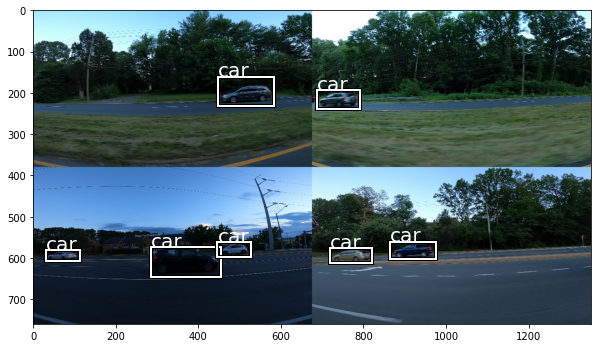

Image id: 6
Original Image size: (760, 1352)
Image size: (760, 1352, 3)


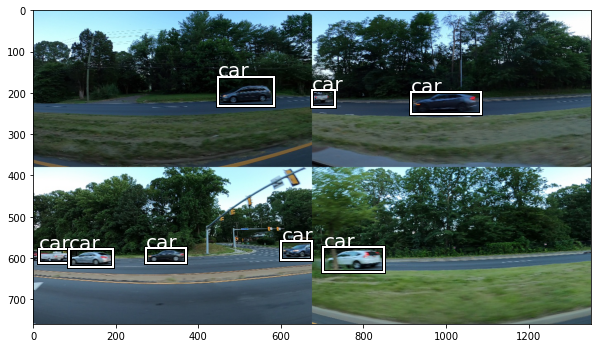

Image id: 6
Original Image size: (760, 1352)
Image size: (760, 1352, 3)


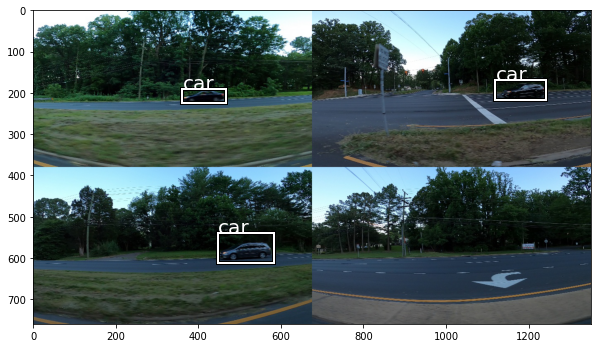

Image id: 6
Original Image size: (760, 1352)
Image size: (760, 1352, 3)


In [66]:
for i in range(3):
    plot_mosaic(4)

Here, we can see several examples of the type of images that are produced. As we haven't (yet) passed any resizing transforms to our mosaic dataset, these images are quite large.

Mosaic augmentation is often applied alongside another transform - Mixup. To visualise what this does, let's disable mosaic for the moment and enable mixup on its own, we can do this as demonstrated below:

In [67]:
mds.enable(apply_mosaic_probability=0, apply_mixup_probability=1)

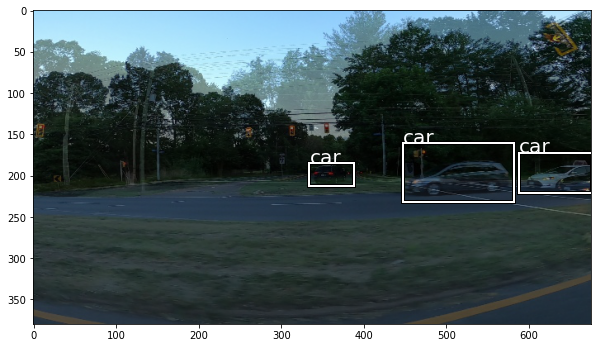

Image id: 6
Original Image size: (380, 676)
Image size: (380, 676, 3)


In [68]:
plot_mosaic(4)

Interesting! We can see that it has combined two images together, which results in some 'ghostly' looking cars and backgrounds! Now, let's enable both transforms and inspect our outputs.

In [69]:
mds.enable(apply_mosaic_probability=1, apply_mixup_probability=1)

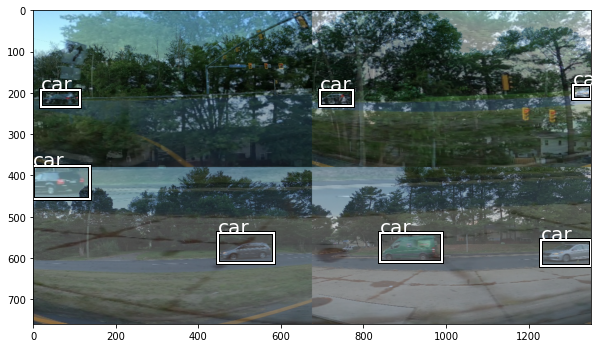

Image id: 6
Original Image size: (760, 1352)
Image size: (760, 1352, 3)


In [70]:
plot_mosaic(4)

Wow! There are quite a lot of cars to detect in our resulting image, in many different positions - which will definitely be a challenge for the model! Notice that when we apply mosaic and mixup together, a single image is mixed with a mosaic.

### Add post-mosaic transforms 

As we noted earlier, the mosaics that we are creating are significantly bigger than the image sizes we will use to train our model, so we will need to do some sort of resizing here. 

The simplest way would be to simply apply a resize transform after creating the mosaic. Whilst this would work, this is likely to result in some very small objects, as we are essentially resizing four images to the size of one; which is likely to become a problem where the domain already contains very small bounding boxes! Additionally, each of our mosaics are structurally quite similar, with an image in each quadrant. Recalling that our aim was to make the model more robust to position changes, this may not actually help that much; as the model is likely just to start looking in the middle of each quadrant.

To overcome this, one approach that we can take is to simply take a random crop from our mosaic. This will still provide the variability in positioning whilst preserving the size and aspect ratio of the target objects. At this point, it may also be a good opportunity to add in some other transforms such as scaling and rotation to add even more variability. 

The exact transforms, and magnitudes, used will be heavily dependent on the images that you are using, so we would recommend experimenting with these setting first - to ensure that all objects are still visible and recognisable - prior to training a model!

We can define the transforms to apply to our mosaic images as demonstrated below. Here, we have chosen a selection of affine transforms - in sensible ranges for our target data - followed by a random crop. Following the original implementation, we are also applying mixup less frequently than mosaic.

In [73]:
from yolov7.mosaic import create_post_mosaic_transform

In [74]:
def create_post_mosaic_transform(
        output_height,
        output_width,
        pad_colour=(0, 0, 0),
        rotation_range=(-10, 10),
        shear_range=(-10, 10),
        translation_percent_range=(-0.2, 0.2),
        scale_range=(0.08, 1.0),
        apply_prob=0.8,
):
    return A.Compose(
        [
            A.Affine(
                cval=pad_colour,
                rotate=rotation_range,
                shear=shear_range,
                translate_percent=translation_percent_range,
                scale=None,
                keep_ratio=True,
                p=apply_prob,
            ),
            A.HorizontalFlip(),
            A.RandomResizedCrop(height=output_height, width=output_width, scale=scale_range),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"], min_visibility=0.25),
    )

In [75]:
mds = MosaicMixupDataset(ds, apply_mixup_probability=0.2, post_mosaic_transforms=create_post_mosaic_transform(640, 640))

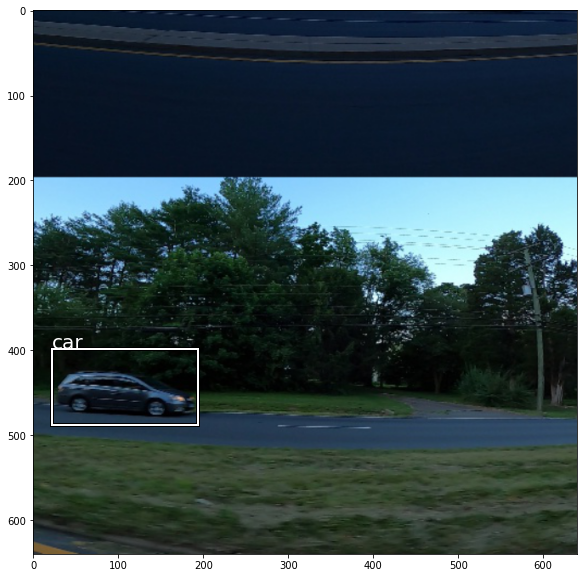

Image id: 6
Original Image size: (760, 1352)
Image size: (640, 640, 3)


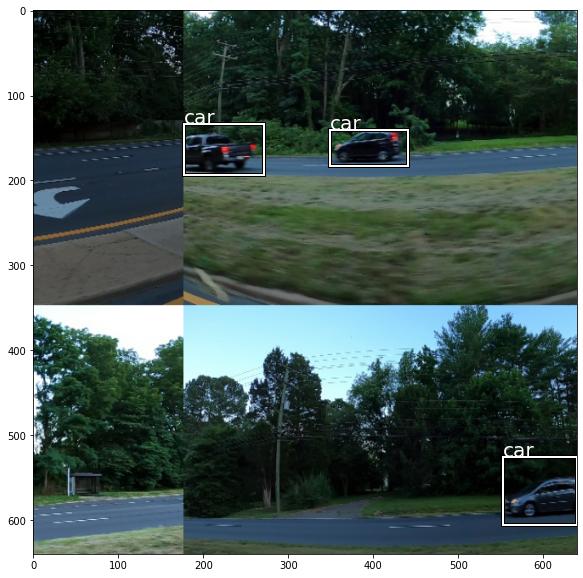

Image id: 6
Original Image size: (760, 1352)
Image size: (640, 640, 3)


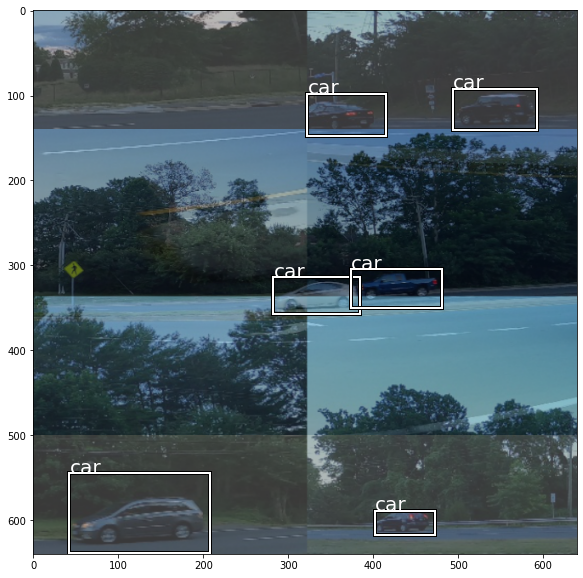

Image id: 6
Original Image size: (760, 1352)
Image size: (640, 640, 3)


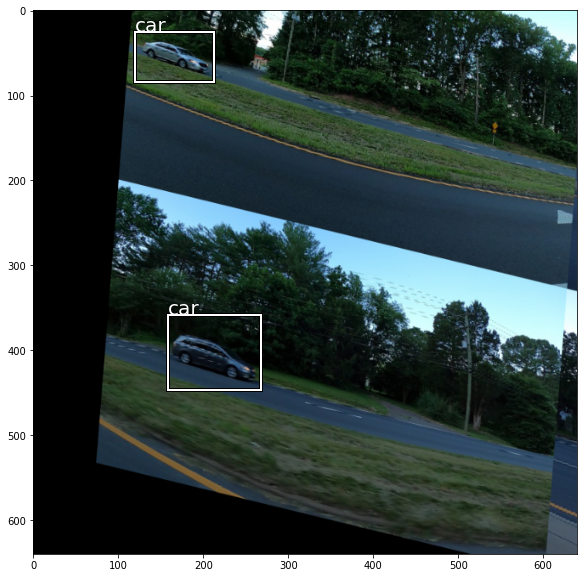

Image id: 6
Original Image size: (760, 1352)
Image size: (640, 640, 3)


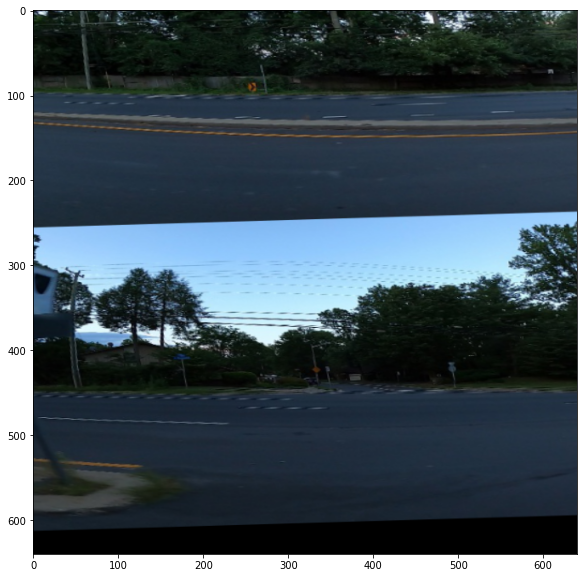

Image id: 6
Original Image size: (760, 1352)
Image size: (640, 640, 3)


In [76]:
for i in range(5):
    plot_mosaic(4)

Looking at these images, we can see a huge amount of variation and the images are now the correct size for training. As we have selected a random scale, we can also see that not every image looks like a mosaic, so these outputs should not be too dissimillar to the images that the model will see during inference. If more extreme augmentations are used - such that there is a noteable difference between the training and inference images - it can be advantageous to disable these shortly before the end of training.

In the official implementation, the authors use mosaics of both 4 and 9 images during training. However, inspecting the outputs of these augmentations when combined with scaling and cropping, in many cases the outputs looked very similar, so we have chosen to omit this here. 

### Applying weight decay to parameter groups

In our simple example earlier, we created our optimizer so that it would optimize all of the parameters of our model. However, if we would like to follow the authors in introducing [weight decay regularization](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9), following the guidance given in [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/pdf/1812.01187.pdf) this may not be optimal; with this paper recommending that weight decay should be applied to only convolutional and fully connected layers.

To implement this in PyTorch, we will need to create two distinct parameter groups to be optimized; one containing our convolutional weights and the other with the remaining parameters. We can do this as demonstrated below:

In [81]:
param_groups = model.get_parameter_groups()
param_groups.keys()

dict_keys(['conv_weights', 'other_params'])

Inspecting the method definition, we can see that this is a simple filter operation:

In [83]:
??model.get_parameter_groups

Signature: model.get_parameter_groups()
Docstring: <no docstring>
Source:   
    def get_parameter_groups(self):
        conv_weights = {
            v.weight
            for k, v in self.model.named_modules()
            if (
                hasattr(v, "weight")
                and isinstance(v.weight, nn.Parameter)
                and not isinstance(v, nn.BatchNorm2d)
            )
        }

        other_params = [p for p in self.model.parameters() if p not in conv_weights]

        return {"conv_weights": list(conv_weights), "other_params": other_params}
File:      /mnt/yolov7/models/yolo.py
Type:      method


Now we can simply pass these to the optimizer:

```
optimizer = torch.optim.SGD(
        param_groups["other_params"], lr=0.01, momentum=0.937, nesterov=True
    )

 optimizer.add_param_group(
        {"params": param_groups["conv_weights"], "weight_decay": weight_decay}
    )
```

### Learning rate scheduling

When training neural networks, we often wish to adjust the value of our learning rate during training; this is done using a learning rate scheduler. Whilst there are many popular schedules, the authors opt for a cosine learning rate schedule - with a linear warmup at the start of training. This has the following shape:

In [93]:
def create_model_and_optimizer():
    model = torch.nn.Linear(2, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, optimizer

In [97]:
from pytorch_accelerated.schedulers import CosineLrScheduler
import matplotlib.pyplot as plt

In [95]:
num_epochs=300
num_steps_per_epoch = 10

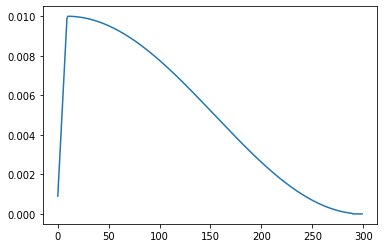

In [98]:
m, o = create_model_and_optimizer()
scheduler = CosineLrScheduler(o, total_num_epochs=num_epochs, num_update_steps_per_epoch=10, num_warmup_epochs=10)
lrs = []

for epoch in range(num_epochs):
    for i in range(num_steps_per_epoch):
        scheduler.step()
    lrs.append(o.param_groups[0]['lr'])
    
plt.plot(lrs)

In practice, we find that a period of warmup, and cooldown - where the learning rate is held at its minimum value - is often a good strategy for this scheduler. Additionally, the scheduler PyTorch-accelerated supports a [k-decay argument](https://arxiv.org/abs/2004.05909) which can be used to adjust how aggressive the annealing is.

For this problem, we found that using k-decay to hold the learning rate at a higher value for longer worked quite well. This schedule, along with warmup and cooldown epochs, can be seen below:

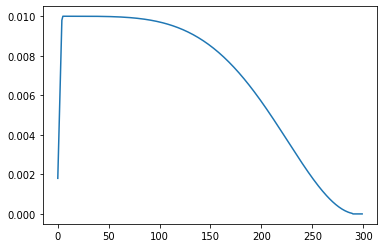

In [104]:
m, o = create_model_and_optimizer()
scheduler = CosineLrScheduler(o, total_num_epochs=num_epochs, num_update_steps_per_epoch=10, num_warmup_epochs=5, num_cooldown_epochs=5, k_decay=2)
lrs = []

for epoch in range(num_epochs):
    for i in range(num_steps_per_epoch):
        scheduler.step()
    lrs.append(o.param_groups[0]['lr'])
    
plt.plot(lrs)

### Gradient accumulation, scaling weight decay

When training a model, the batch size we use is often determined by our hardware; as we want to try to maximise the amount of data that we can put on the GPU. However, some considerations must be made:

- For very small batch sizes, we are unable to approximate the gradients of the whole dataset. This can result in unstable training.
- Modifying the batch size can result in different settings being needed for hyperparameters such as the learning rate and weight decay. This can make it difficult to find a consistent set of hyperparameters.

To overcome this, the authors use use a technique called [*gradient accumulation*](https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa), in which the gradients from multiple steps are accumulated to simulate a bigger batch size. For example, suppose that the maximum batch size that we can fit on our GPU is 8. Instead of updating the parameters of the model at the end of each batch, we can save gradient values, proceed to the next batch and add these new gradients. After a designated number of steps, we then perform the update; if we set our number of steps to 4, this is roughly equivalent of using a batch size of 32!

In PyTorch, this could be performed manually as follows:

```
num_accumulation_steps = 4  

# loop through ennumerated batches
for step, (inputs, labels) in enumerate(data_loader):

        model_outputs = model(inputs)
        loss  = loss_fn(model_outputs, labels)

        # normalize loss to account for batch accumulation
        loss = loss / num_accumulation_steps 

        # calculate gradients, these are summed automatically
        loss.backward()

        if ((step + 1) % num_accumulation_steps == 0) or (step + 1 == len(data_loader)):
            perform weight update
            optimizer.step()
            optimizer.zero_grad()

```

In the original implementation, the number of gradient accumulation steps is selected so that the total batch size (across all processes) is at least 64; which mitigates both of the issues discussed earlier. Additionally, the authors scale the weight decay used based on the batch size in the following way:

```
nominal_batch_size = 64
num_accumulate_steps = max(round(nominal_batch_size / total_batch_size), 1)

base_weight_decay = 0.0005
scaled_weight_decay = (
    base_weight_decay * total_batch_size * num_accumulate_steps / nominal_batch_size
)
```

We can visualise these relationships below:

In [135]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256]

def calculate_scaling(total_batch_size):
    num_accumulate_steps = max(round(nominal_batch_size / total_batch_size), 1)

    base_weight_decay = 0.0005
    scaled_weight_decay = (
        base_weight_decay * total_batch_size * num_accumulate_steps / nominal_batch_size
    )
    return num_accumulate_steps, scaled_weight_decay

accum_steps = []
wd = []
for bs in batch_sizes:
    num_accumulate_steps, scaled_weight_decay = calculate_scaling(bs)
    accum_steps.append(num_accumulate_steps)
    wd.append(scaled_weight_decay)
    

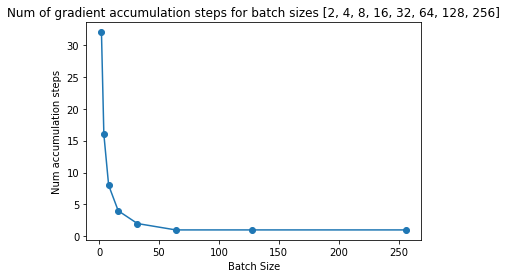

In [154]:
fig, ax = plt.subplots()
ax.scatter(batch_sizes, accum_steps)
ax.plot(batch_sizes, accum_steps)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Num accumulation steps')
ax.set_title(f'Num of gradient accumulation steps for batch sizes {batch_sizes}')
ax.set

plt.show()

Looking first at the number of accumulation steps, we can see that the number of accumulation steps decreases until we hit our nominal batch size, and then gradient accumulation is no longer needed.

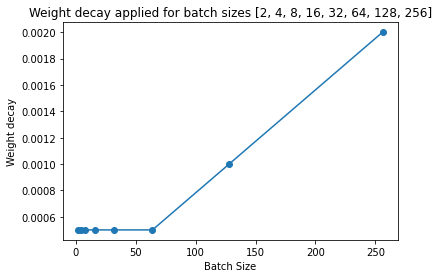

In [156]:
fig, ax = plt.subplots()
ax.scatter(batch_sizes, wd)
ax.plot(batch_sizes, wd)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Weight decay')
ax.set_title(f'Weight decay applied for batch sizes {batch_sizes}')

plt.show()

Now looking at the amount of weight decay used, we can see that it is held at the base value until the nominal batch size is reached, and then is scaled linearly with the batch size; with more weight decay applied as the batch size gets bigger.

### Model EMA

When training a model, it can be beneficial to set the values for the model weights by taking a moving average of the parameters that were observed across the entire training run, as opposed to using the parameters obtained after the last incremental update. This is often done by maintaining an exponentially weighted everage (EMA) of the model parameters, in practice, this usually means maintaining another copy of the model to store these averaged weights. However, rather than updating all of the parameters of this model after every update step, we set these parameters using a linear combination of the existing parameter values and the updated values.

This is done using the following formula:
```
updated_EMA_model_weights =

decay * EMA_model_weights + (1. — decay) * updated_model_weights
```

where the _decay_ is a parameter that we set. For example, if we set decay=0.99, we have:

```
updated_EMA_model_weights =

0.99 * EMA_model_weights + 0.01 * updated_model_weights
```

which we can see is keeping 99% of the existing state and only 1% of the new state!

To understand why this may be beneficial, let’s consider the case that our model, in an early stage of training, performs exceptionally poorly on a batch of data. This may result in a large update update to our parameters, overcompensating for the high loss obtained, which will be detrimental for the upcoming batches. By only incorporating only a small percentage of the latest parameters, large updates will be ‘smoothed’, and have less of an overall impact on the model’s weights. Sometimes, these averaged parameters can sometimes produce significantly better results during evaluation, and this technique has been employed in several training schemes for popular models such as training MNASNet, MobileNet-V3 and EfficientNet; using the implementation included in TensorFlow. 

The approach to EMA taken by the Yolo authors is slightly different to other implementations as, instead of using a fixed decay, the amount of decay changes based on the number of updates that have been made. We can extend the ModelEMA class included with PyTorch-accelerated to implement this behaviour as defined below:

In [157]:
from yolov7.utils import Yolov7ModelEma

In [159]:
??Yolov7ModelEma

Init signature: Yolov7ModelEma(model, decay=0.9999)
Docstring:     
Maintains a moving average of everything in the model state_dict (parameters and buffers), based on the ideas
from https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage.

This class maintains a copy of the model that we are training. However,
rather than updating all of the parameters of this model after every update step,
we set these parameters using a linear combination of the existing parameter values and the updated values

.. Note:: It is important to note that this class is sensitive to where it is initialised.
    During distributed training, it should be applied before before the conversion to :class:`~torch.nn.SyncBatchNorm`
    takes place and before the :class:`torch.nn.parallel.DistributedDataParallel` wrapper is used!
Source:        
class Yolov7ModelEma(ModelEma):
    def __init__(self, model, decay=0.9999):
        super().__init__(model, decay)
        self.num_updates = 0
      

Here, we can see that the decay is set by calling a function after each update. Let's visualise how this looks:

In [162]:
from torch import nn

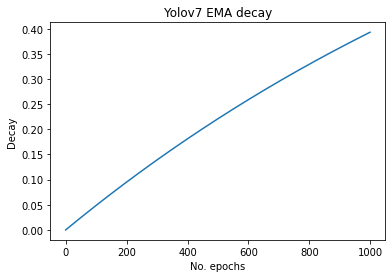

In [175]:
model_ema = Yolov7ModelEma(nn.Linear(1, 2))
decay = []

for i in range(1000):
    decay.append(model_ema.decay_fn(i))
    

fig, ax = plt.subplots()
ax.plot(decay)
ax.set_xlabel('No. epochs')
ax.set_ylabel('Decay')
ax.set_title('Yolov7 EMA decay')

plt.show()

From this, we can seee that the amount of decay increases with the number of updates, which is once per epoch. 

Recalling the formulas above, this means that, initially, we favour using the updated model weights rather than a historical average. However, as training progresses, we start to incorporate more of the averaged weights from previous epochs. This is an interesting departure from the usual usage of this technique, which is designed to help the EMA model converge more quickly in earlier epochs.

### Selecting appropriate anchor box sizes

Recalling the earlier discussion on anchor boxes, and how these play an important part on how Yolov7 is able to detect objects, lets look at how we can evaluate whether our chosen anchors are suitable for our problem and, if not, find some sensible choices for our dataset.

The approach here is largely adapted from the autoanchor approach used in Yolov5, which was also used with Yolov7.

## Evaluating current anchor boxes

The simplest approach would be to simply use the same anchors as used for COCO, which are already bundled with the defined architectures.

In [7]:
from yolov7 import create_yolov7_model

In [8]:
model = create_yolov7_model('yolov7', pretrained=False)

In [9]:
model.detection_head.anchor_grid

tensor([[[[[[ 12.,  16.]]],


          [[[ 19.,  36.]]],


          [[[ 40.,  28.]]]]],




        [[[[[ 36.,  75.]]],


          [[[ 76.,  55.]]],


          [[[ 72., 146.]]]]],




        [[[[[142., 110.]]],


          [[[192., 243.]]],


          [[[459., 401.]]]]]])

By default these are the ones from coco. Here we can see that we have 3 groups, one for each layer of the feature pyramid network. The numbers correspond to the width and height of the anchors that will be generated.

The FPN (Feature Pyramid Network) has three outputs and each output's role is to detect objects according to their scale. For example:

- P3/8 is for detecting smaller objects.
- P4/16 is for detecting medium objects.
- P5/32 is for detecting bigger objects.
So when you're going to detect smaller objects you need to use smaller anchor boxes and for medium objects you should use medium scale anchor boxes, so on

TODO: Should have already explained what anchors are in a different section.

In [10]:
current_anchors = model.detection_head.anchor_grid.clone().cpu().view(-1, 2); current_anchors

tensor([[ 12.,  16.],
        [ 19.,  36.],
        [ 40.,  28.],
        [ 36.,  75.],
        [ 76.,  55.],
        [ 72., 146.],
        [142., 110.],
        [192., 243.],
        [459., 401.]])

To evaluate our current anchor boxes, we can calculate the best possible recall, which would occur if the model was able to successfully match an appropriate anchor box with a ground truth. 

### Find and Resize ground truth bounding boxes

To evaluate our anchor boxes, we first need some knowedge of the shapes and sizes of the objects in our dataset. However, before we can evaluate, we need to resize the width and height of our ground truth boxes based on the size of the images that we will train on - for this architecture, this is recommended to be 640.

Let's start by finding the width and height of all ground truth boxes in the training set. We can calculate these as demonstrated below:

In [11]:
train_annotations_df = train_df.query('has_annotation == True').copy()

In [12]:
train_annotations_df['h'] = train_annotations_df['ymax'] -  train_annotations_df['ymin']
train_annotations_df['w'] = train_annotations_df['xmax'] -  train_annotations_df['xmin']

In [13]:
train_annotations_df

image        xmin        ymin        xmax        ymax  \
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   
5    vid_4_10100.jpg  447.568741  160.625804  582.083936  232.517696   
..               ...         ...         ...         ...         ...   
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284   
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895   
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652   
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864   
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196   

    class_name  has_annotation  image_id  class_id          h           w  
0          car            True         0       0.0  36.190476   46.468886  
1          car            True         1       0.0  49.395109  105.166425  
2          car            True         3       0.0  59.665380  122.775687  
4          car            True         4       0.0  51.840412  115.927641  
5          car            True         6       0.0  71.891892  134.515195  
..         ...             ...       ...       ...        ...         ...  
554        car            True       994       0.0  37.901554   49.235251  
555        car            True       995       0.0  94.015544  206.788055  
556        car            True       996       0.0  70.880829  141.797524  
557        car            True       999       0.0  56.606218  129.488711  
558        car            True      1000       0.0  55.621762  127.026948  

[397 rows x 11 columns]

In [38]:
raw_gt_wh = train_annotations_df[['w', 'h']].values

Next, we will need the height and width of our images. Sometimes, we have this information ahead of time, in which case we can use this knowledge directly. Otherwise, We can do this as follows

In [15]:
from PIL import Image
from tqdm.contrib.concurrent import process_map

In [16]:
def find_image_size(image_path):
    image = Image.open(image_path)
    w, h = image.size
    return (image_path.parts[-1], (w, h))

image_sizes = process_map(find_image_size, [images_path/p for p in train_df.image.unique()])


100%|███████████████████████████████████████████████████| 324/324 [00:00<00:00, 5619.21it/s]


In [17]:
image_sizes_df = pd.DataFrame(dict(image_sizes)).T.reset_index().rename(columns={'index': 'image', 0: 'image_w', 1:'image_h'})

In [18]:
image_sizes_df

image  image_w  image_h
0     vid_4_1000.jpg      676      380
1    vid_4_10000.jpg      676      380
2    vid_4_10040.jpg      676      380
3    vid_4_10060.jpg      676      380
4    vid_4_10100.jpg      676      380
..               ...      ...      ...
319  vid_4_13060.jpg      676      380
320  vid_4_13100.jpg      676      380
321  vid_4_13240.jpg      676      380
322  vid_4_13280.jpg      676      380
323  vid_4_13300.jpg      676      380

[324 rows x 3 columns]

We can now merge this with our existing dataframe

In [19]:
train_annotations_df = pd.merge(train_annotations_df, image_sizes_df, on='image'); train_annotations_df

image        xmin        ymin        xmax        ymax  \
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   
3    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   
4    vid_4_10100.jpg  447.568741  160.625804  582.083936  232.517696   
..               ...         ...         ...         ...         ...   
392   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284   
393   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895   
394   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652   
395   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864   
396   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196   

    class_name  has_annotation  image_id  class_id          h           w  \
0          car            True         0       0.0  36.190476   46.468886   
1          car            True         1       0.0  49.395109  105.166425   
2          car            True         3       0.0  59.665380  122.775687   
3          car            True         4       0.0  51.840412  115.927641   
4          car            True         6       0.0  71.891892  134.515195   
..         ...             ...       ...       ...        ...         ...   
392        car            True       994       0.0  37.901554   49.235251   
393        car            True       995       0.0  94.015544  206.788055   
394        car            True       996       0.0  70.880829  141.797524   
395        car            True       999       0.0  56.606218  129.488711   
396        car            True      1000       0.0  55.621762  127.026948   

     image_w  image_h  
0        676      380  
1        676      380  
2        676      380  
3        676      380  
4        676      380  
..       ...      ...  
392      676      380  
393      676      380  
394      676      380  
395      676      380  
396      676      380  

[397 rows x 13 columns]

In [20]:
image_sizes = train_annotations_df[['image_w', 'image_h']].values

Now, we can use this information to get the resized widths and heights of our ground truth targets, with respect to our target image size. To preserve the aspect ratios of the objects in our images, the recommended approach to resizing is to scale the image so that the longest size is equal to our target size. We can do this using the function below:

In [21]:
from yolov7.anchors import calculate_resized_gt_wh

In [22]:
??calculate_resized_gt_wh

Signature: calculate_resized_gt_wh(image_sizes, gt_wh, target_image_size=640)
Docstring: <no docstring>
Source:   
def calculate_resized_gt_wh(image_sizes, gt_wh, target_image_size=640):
    # image sizes array of [w, h] , either np.array([[w, h]]) or per image

    normalized_gt_wh = gt_wh / image_sizes

    # find target image sizes, assuming resizing so that the longest side is the target size
    target_image_sizes = (
        target_image_size * image_sizes / image_sizes.max(1, keepdims=True)
    )

    # find wh of boxes for target size
    wh = target_image_sizes * normalized_gt_wh

    tiny_boxes_exist = (wh < 3).any(1).sum()
    if tiny_boxes_exist:
        print(
            f"WARNING: Extremely small objects found. {tiny_boxes_exist} of {len(wh)} labels are < 3 pixels in size."
        )

    wh = wh[(wh >= 2.0).any(1)]  # filter > 2 pixels

    return wh
File:      /mnt/yolov7/anchors.py
Type:      function


In [41]:
raw_gt_wh.shape

(397, 2)

In [39]:
gt_wh = calculate_resized_gt_wh(raw_gt_wh, image_sizes, target_image_size=640); gt_wh[:5]

array([[ 43.99421122,  34.26317273],
       [ 99.56584662,  46.76460062],
       [116.23733718,  56.48793344],
       [109.75397973,  49.07967981],
       [127.35166419,  68.06332961]])

Alternatively, as all of our images are the same size in this case, we could simply specify a single image size.

In [40]:
calculate_resized_gt_wh(raw_gt_wh, image_sizes=np.array([[676, 380]]), target_image_size=640)[:5]

array([[ 43.99421122,  34.26317273],
       [ 99.56584662,  46.76460062],
       [116.23733718,  56.48793344],
       [109.75397973,  49.07967981],
       [127.35166419,  68.06332961]])

Note that we have also filtered out any boxes what will be incredibly small (less than 3 pixels in either height or width), with respect to the new image size, as these boxes are usually too small to be considered useful!

### Calculating Best Possible Recall

Now that we have the width and height of all ground truth boxes in our training set, we can evaluate our current anchor boxes as follows:

In [43]:
from yolov7.anchors import calculate_best_possible_recall, LOSS_ANCHOR_MULTIPLE_THRESHOLD

In [44]:
??calculate_best_possible_recall

Signature: calculate_best_possible_recall(anchors, gt_wh)
Source:   
def calculate_best_possible_recall(anchors, gt_wh):
    """
    Given a tensor of anchors and and an array of widths and heights for each bounding box in the dataset,
    calculate the best possible recall that can be obtained if every box was matched to an appropriate anchor.

    :param anchors: a tensor of shape [N, 2] representing the width and height of each anchor
    :param gt_wh: a tensor of shape [N, 2] representing the width and height of each ground truth bounding box

    """
    best_anchor_ratio = calculate_best_anchor_ratio(anchors=anchors, wh=gt_wh)
    best_possible_recall = (
        (best_anchor_ratio > 1.0 / LOSS_ANCHOR_MULTIPLE_THRESHOLD).float().mean()
    )

    return best_possible_recall
File:      /mnt/yolov7/anchors.py
Type:      function


In [46]:
calculate_best_possible_recall(current_anchors, gt_wh)

tensor(1.)

From this, we can see that the current anchor boxes are a good fit for this dataset; which makes sense, as the images are quite similar to those in COCO.

### How does this work?

At this point, you may be wondering, how exactly do we calculate the best possible recall. To answer this, let's go through the process manually.


Intuitively, we would like to ensure that at least one anchor can be matched to each ground truth box. Whilst we could do this by framing it as an optimization problem - how do we match each ground truth box with its optimal anchor - this would introduce a lot of complexity for what we are trying to do.

Given an anchor box, we need a simpler way of measuring how well it can be made to fit a ground truth box. Let's examine one approach that can be taken to do this, starting with the width and height of a single ground truth box.


In [48]:
gt_box_wh = gt_wh[0]; gt_box_wh

array([43.99421122, 34.26317273])

For each anchor box, we can inspect the ratios of its height and width when compared to the height and width of our ground truth target, and use this to understand where the biggest differences are.

In [49]:
current_anchors/gt_box_wh

tensor([[ 0.2728,  0.4670],
        [ 0.4319,  1.0507],
        [ 0.9092,  0.8172],
        [ 0.8183,  2.1889],
        [ 1.7275,  1.6052],
        [ 1.6366,  4.2611],
        [ 3.2277,  3.2104],
        [ 4.3642,  7.0922],
        [10.4332, 11.7035]], dtype=torch.float64)

As the scale of these ratios will depend on whether the anchor box sides are greater or smaller than the sides of our ground truth box, we can ensure that our magnitudes are in the range [0, 1] by also calculating the reciprocal and taking the minimum ratios for each anchor. 


In [50]:
symmetric_size_ratios = torch.min(current_anchors/gt_box_wh, gt_box_wh/current_anchors); symmetric_size_ratios

tensor([[0.2728, 0.4670],
        [0.4319, 0.9518],
        [0.9092, 0.8172],
        [0.8183, 0.4568],
        [0.5789, 0.6230],
        [0.6110, 0.2347],
        [0.3098, 0.3115],
        [0.2291, 0.1410],
        [0.0958, 0.0854]], dtype=torch.float64)

From this, we now have an indication of how well, independently, the width and height of each anchor box 'fits' to our ground truth target. 

Now, our challenge is how to evaluate the matching of the the width and height together!

One way we can approach this is, to take the minimum ratio for each anchor; representing the side that worst matches our ground truth.

In [51]:
worst_side_size_ratio = symmetric_size_ratios.min(-1).values; worst_side_size_ratio

tensor([0.2728, 0.4319, 0.8172, 0.4568, 0.5789, 0.2347, 0.3098, 0.1410, 0.0854],
       dtype=torch.float64)

The reason why we have selected the worst fitting side here, is because we know that the other side matches our target *at least* as well as the one selected; we can think of this as the worst case scenario!

Now, let's select the anchor box which matches the best out of these options, this is simply the largest value.

In [52]:
best_anchor_ratio = worst_side_size_ratio.max(-1).values; best_anchor_ratio

tensor(0.8172, dtype=torch.float64)

Out of the worst fitting options, this is our selected match!

Recalling that the loss function only looks to match anchor boxes that are up to 4 times greater or smaller than the size of the ground truth target, we can now verify whether this anchor is within this range and would be considered a successful match.

We can do that as demonstrated below, taking the reciprical of our loss multiple, to ensure that it is in the same range as our value:

In [53]:
LOSS_ANCHOR_MULTIPLE_THRESHOLD

4

In [54]:
best_anchor_ratio > 1. / LOSS_ANCHOR_MULTIPLE_THRESHOLD

tensor(True)

From this, we can see that at least one of our anchors could be successfully matched to our selected ground truth target!

Now that we understand the sequence of steps, we can now apply the same logic to all of our ground truth boxes to see how many matches we can obtain with our current set of anchors:

In [55]:
symmetric_size_ratios = torch.min(current_anchors[None]/gt_wh[:, None],
                                  gt_wh[:, None]/current_anchors[None])
worst_side_size_ratio = symmetric_size_ratios.min(-1).values
best_anchor_ratio = worst_side_size_ratio.max(-1).values

In [56]:
best_anchor_ratio > 1. / LOSS_ANCHOR_MULTIPLE_THRESHOLD

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

Now that we have calculated, for each ground truth box, whether it has a match. We can take the mean number of matches to find out best possible recall; in our case, this is 1, as we saw earlier!

In [57]:
best_possible_recall = (best_anchor_ratio > 1. / LOSS_ANCHOR_MULTIPLE_THRESHOLD).float().mean(); best_possible_recall

tensor(1.)

### Selecting new anchor boxes

Whilst using the pre-defined anchors may be a good choice for similar datasets, this may not be appropriate for all datasets, for example, those that contain lots of small objects. In these cases, a better approach may be to select entirely new anchors.

Let's explore how we can do this!

First, let's define the number of anchors that we need for our architecture.

In [81]:
num_anchors = current_anchors.shape[0]; num_anchors

9

Now, based on our bounding boxes, we need to define a sensible set widths and heights of anchor templates. One way that we can estimate this is by using Kmeans to cluster our ground truth aspect ratios, based on the number of anchors that we need. We can then use these centroids as our starting estimates. We can do this using the following function:

In [82]:
from yolov7.anchors import estimate_anchors

In [83]:
??estimate_anchors

Signature: estimate_anchors(num_anchors, gt_wh)
Source:   
def estimate_anchors(num_anchors, gt_wh):
    """
    Given a target number of anchors and an array of widths and heights for each bounding box in the dataset,
    estimate a set of anchors using the centroids from Kmeans clustering.

    :param num_anchors: the number of anchors to return
    :param gt_wh: an array of shape [N, 2] representing the width and height of each ground truth bounding box

    """
    print(f"Running kmeans for {num_anchors} anchors on {len(gt_wh)} points...")
    std_dev = gt_wh.std(0)
    proposed_anchors, _ = kmeans(
        gt_wh / std_dev, num_anchors, iter=30
    )  # divide by std so they are in approx same range
    proposed_anchors *= std_dev

    return proposed_anchors
File:      /mnt/yolov7/anchors.py
Type:      function


In [84]:
proposed_anchors = estimate_anchors(num_anchors, gt_wh); proposed_anchors

Running kmeans for 9 anchors on 397 points...


array([[157.29889337,  57.47936534],
       [ 70.37782144,  28.9259909 ],
       [117.67344588,  55.91906451],
       [ 71.90866699,  50.8658278 ],
       [186.28917826,  84.09961313],
       [ 38.3042379 ,  25.61764762],
       [ 56.74676871,  36.96437289],
       [112.83692506,  42.92073289],
       [ 90.20439918,  36.43405811]])

Here, we can see that we now have a set of anchor templates that we can use as a starting point. As before, let's calculate our best possible recall using these anchors:

In [85]:
calculate_best_possible_recall(proposed_anchors, gt_wh)

tensor(1.)

Once again, we see that our best possible recall is 1, which means that these anchors are also a good fit for our problem!

Whilst it is perhaps unnecessary in this case, we may be able improve these anchors further using a [genetic algorithm](https://www.geeksforgeeks.org/genetic-algorithms/). Following this methodology, we can define a *fitness* (or reward) function to measure how well our anchors match our data and make small, random changes to our anchors to try and maximise this function. 

In this case we can define our fitness function as follows:

In [86]:
from yolov7.anchors import anchor_fitness, evolve_anchors

In [87]:
??anchor_fitness

Signature: anchor_fitness(anchors, wh)
Source:   
def anchor_fitness(anchors, wh):
    """
    A fitness function that can be used to evolve a set of anchors. This function calculates the mean best anchor ratio
    for all matches that are within the multiple range considered during the loss calculation.
    """
    best_anchor_ratio = calculate_best_anchor_ratio(anchors=anchors, gt_wh=wh)
    return (
        best_anchor_ratio
        * (best_anchor_ratio > 1 / LOSS_ANCHOR_MULTIPLE_THRESHOLD).float()
    ).mean()
File:      /mnt/yolov7/anchors.py
Type:      function


Here, we are taking the best anchor ratio for each match that will be considered during the loss calculation. If an anchor box is more than four times greater or smaller than its matched bounding box, it will not contribute to our score. Let's use this to calculate a fitness score for our proposed anchors:

In [88]:
anchor_fitness(proposed_anchors, gt_wh)

tensor(0.8825, dtype=torch.float64)

 Now, let's use this as the fitness function when optimizing our anchors, as demonstrated below:

In [99]:
evolved_anchors = evolve_anchors(proposed_anchors, gt_wh, anchor_fitness_fn=anchor_fitness, num_iterations=30000); evolved_anchors

Evolving anchors with Genetic Algorithm: fitness = 0.8855: 100%|█| 30000/30000 [00:19<00:00,


array([[156.06907735,  61.09621462],
       [ 66.80622862,  29.0438958 ],
       [136.33063134,  52.56100946],
       [ 80.06700492,  36.42821897],
       [179.52356295,  83.0822995 ],
       [ 37.64336168,  29.35155407],
       [ 52.00907081,  37.50677223],
       [114.96001811,  44.23679448],
       [ 99.66602472,  37.86939469]])

Inspecting the definition of this function, we can see that, for a specified number of iterations, we are simply sampling random noise from a normal distribution and using this to mutate our anchors. If this change leads to an increased score, we keep these as our anchors! 


In [79]:
??evolve_anchors

Signature:
evolve_anchors(
    proposed_anchors,
    gt_wh,
    num_iterations=1000,
    mutation_probability=0.9,
    mutation_noise_mean=1,
    mutation_noise_std=0.1,
    anchor_fitness_fn=<function anchor_fitness at 0x7f17b52be5f0>,
    verbose=False,
)
Source:   
def evolve_anchors(
    proposed_anchors,
    gt_wh,
    num_iterations=1000,
    mutation_probability=0.9,
    mutation_noise_mean=1,
    mutation_noise_std=0.1,
    anchor_fitness_fn=anchor_fitness,
    verbose=False,
):
    """
    Use a genetic algorithm to mutate the given anchors to try and optimise them based on the given widths and heights of the
    ground truth boxes based on the provided fitness function. Anchor dimensions are mutated by adding random noise sampled
    from a normal distribution with the mean and standard deviation provided.

    :param proposed_anchors: a tensor containing the aspect ratios of the anchor boxes to evolve
    :param gt_wh: a tensor of shape [N, 2] representing the width and heig

Let's see whether this has improved our score at all:

In [98]:
anchor_fitness(evolved_anchors, gt_wh)

tensor(0.8876, dtype=torch.float64)

We can see that our evolved anchors have a better fitness score than our original proposed anchors, as we would expect!

Now, all that is left to do is to sort the anchors into a rough ascending order, considering the smallest dimension for each anchor.

In [101]:
evolved_anchors = torch.as_tensor(evolved_anchors)[torch.sort(torch.as_tensor(evolved_anchors.min(-1))).indices]

In [103]:
calculate_best_possible_recall(evolved_anchors, gt_wh)

tensor(1.)

### Putting it all together

Now that we understand the process, we could calculate our anchors for our dataset in a single step using the following function.

In [104]:
from yolov7.anchors import calculate_anchors

In [105]:
calculate_anchors(current_anchors, image_sizes, gt_wh, target_image_size=640, best_possible_recall_threshold=0.98)

Best Possible Recall (BPR) = 1.0000

tensor([[ 12.,  16.],
        [ 19.,  36.],
        [ 40.,  28.],
        [ 36.,  75.],
        [ 76.,  55.],
        [ 72., 146.],
        [142., 110.],
        [192., 243.],
        [459., 401.]])

In this case, as our best possible recall is already greater than the threshold, we can keep our original anchors!

## Run training

Now we have explored some of the tecnhiques used in the original training recipe, let's update our training script to include some of these features. An updated script is presented below:

In [176]:
!cat example/train_cars_ema.py

import os
import random
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from func_to_script import script
from PIL import Image
from pytorch_accelerated.callbacks import (
    ModelEmaCallback,
    ProgressBarCallback,
    SaveBestModelCallback,
    get_default_callbacks,
)
from pytorch_accelerated.schedulers import CosineLrScheduler
from torch.utils.data import Dataset

from yolov7 import create_yolov7_model
from yolov7.dataset import (
    Yolov7Dataset,
    create_base_transforms,
    create_yolov7_transforms,
    yolov7_collate_fn,
)
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from yolov7.loss_factory import create_yolov7_loss
from yolov7.mosaic import MosaicMixupDataset, create_post_mosaic_transform
from yolov7.trainer import Yolov7Trainer, filter_eval_predictions, DisableAugmentationCallback
from yolov7.utils import SaveBatchesCallback, Yolov7ModelEma


def load_cars_df(annotations_file_path, imag

Launching training once again, [as described here](https://pytorch-accelerated.readthedocs.io/en/latest/quickstart.html), using a single V100 GPU with fp16 enabled, after 300 epochs we obtained a mAP of `0.997`, for both the model and the EMA model; a marginal increase over our transfer learning run, and probably the maximum performance that can be achieved on this dataset!

## Conclusion

Hopefully that has provided a somewhat comprehensive overview of some of the most interesting ideas from the Yolov7 training process, and how these can be applied in custom training scripts.